# imports

In [1]:

import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns### visualizations 
import datetime
import io 
import os 
from tensorflow.keras.layers import Layer
import random 
from PIL import Image  
import tensorflow_datasets as tfds 
import tensorflow_probability as tfp 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, RandomContrast,Resizing, Rescaling 
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks  import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1 
from tensorboard.plugins.hparams import api as hp


# Wandb Install, Login, Initialization and Configuration

In [2]:
!pip install wandb

In [3]:

import wandb
from wandb.keras import WandbCallback

In [4]:
!wandb login 4b47b0292b005c7b73db50f9447705e669452f1d

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\fnaic\.netrc


In [5]:
#wandb.init(project="my-project", entity="wissal-fnaich-ai")
###wandb.tensorboard.patch(root_logdir="./logs")
wandb.init(project="my-project", entity="wissal-fnaich-ai", sync_tensorboard=True)

wandb: Currently logged in as: wissal-fnaich (wissal-fnaich-ai). Use `wandb login --relogin` to force relogin


In [6]:

wandb.config = { "LEARNING_RATE": 0.001, "N_EPOCHS": 5, "BATCH_SIZE": 128, "DROPOUT_RATE": 0.0, "IM_SIZE": 224, "REGULARIZATION_RATE": 0.0, "N_FILTERS": 6, "KERNEL_SIZE": 3, "N_STRIDES": 1, "POOL_SIZE": 2, "N_DENSE_1": 100, "N_DENSE_2": 10, } 
CONFIGURATION = wandb.config

# Data Preparation

Data Loading

In [7]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

In [8]:

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset) 
    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [9]:

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1 
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
print(list(train_dataset.take(5).as_numpy_iterator()), 
      list(val_dataset.take(5).as_numpy_iterator()), 
      list(test_dataset.take(5).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

Dataset Visualization

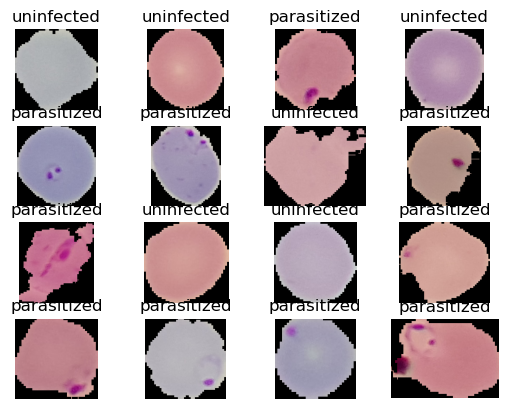

In [10]:

for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image) 
    plt.title(dataset_info.features['label'].int2str(label)) 
    plt.axis('off')

In [11]:
dataset_info.features['label'].int2str(0)

'parasitized'

# Data Preprocessing


Data Augmentation + Normalazation (or stardardization)   CNN

In [12]:
def visualize(original, augmented): 
    plt.subplot(1,2,1) 
    plt.imshow(original)
    plt.subplot(1,2,2) 
    plt.imshow(augmented)

In [13]:

original_image, label = next(iter(train_dataset))

augmented_image = tf.image.adjust_saturation(original_image, saturation_factor = 0.3)


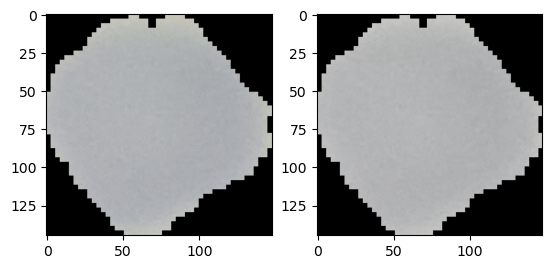

In [14]:
visualize(original_image, augmented_image)

In [15]:
IM_SIZE = 224

@tf.function
def resize_rescale(image, label):
    print("Forme originale de l'image :", image.shape)  # Pour le débogage
    # Assurez-vous que l'image a 3 ou 4 dimensions
    assert len(image.shape) == 3 or len(image.shape) == 4, "L'image doit avoir 3 ou 4 dimensions"
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label




In [16]:

class RotNinety(Layer): 
    def __init__(self):
        super().__init__()
        @tf.function
        def call(self, image):
            return tf.image.rot90(image)

In [17]:

### tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([ Resizing(IM_SIZE, IM_SIZE), Rescaling(1./255), ])

### tf.image augment
@tf.function
def augment(image, label):
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image) 
    #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
    image = tf.image.flip_left_right(image)
    return image, label

In [18]:

augment_layers = tf.keras.Sequential([ RandomRotation(factor = (0.25, 0.2501),), RandomFlip(mode='horizontal',), RandomContrast(factor=0.1), ])
@tf.function 
def augment_layer(image, label):
    # Applique d'abord le redimensionnement et la mise à l'échelle
    processed_image = resize_rescale_layers(image)
    # Puis applique les augmentations
    augmented_image = augment_layers(processed_image, training=True)
    return augmented_image, label

Data Loading

In [19]:

BATCH_SIZE = 32
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
#train_dataset

Forme originale de l'image : (None, None, 3)


In [20]:

train_dataset = ( train_dataset .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
                 .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE) .batch(BATCH_SIZE) 
                 .prefetch(tf.data.AUTOTUNE) )

In [21]:

val_dataset = ( val_dataset .shuffle(buffer_size = 32) 
               .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
               .batch(BATCH_SIZE) )


Albumentations

In [22]:

!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations 'C:\Users\fnaic\AppData\Local\Temp\pip-req-build-hwiensxu'


  Cloning https://github.com/albu/albumentations to c:\users\fnaic\appdata\local\temp\pip-req-build-hwiensxu
  Resolved https://github.com/albu/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2

In [23]:
import albumentations as A
import tensorflow as tf
import matplotlib.pyplot as plt





transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ], p=0.3),
    A.RandomRotate90(),
    #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, always_apply=False, p=0.5),
    #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

def aug_albument(image):
    data = {"image": image}
    augmented = transforms(**data)
    image = augmented["image"]
    image = tf.cast(image / 255., tf.float32)
    return image

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    aug_img.set_shape([IM_SIZE, IM_SIZE, 3])
    return aug_img, label


   






  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [24]:
BATCH_SIZE = 32
#train_dataset = train_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True).map( process_data, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [25]:

IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS'] 
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE'] 
POOL_SIZE = CONFIGURATION['POOL_SIZE'] 
N_STRIDES = CONFIGURATION['N_STRIDES'] 
lenet_model = tf.keras.Sequential([ InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)), Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid', activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)), BatchNormalization(), MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2), Dropout(rate = DROPOUT_RATE ), Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)), BatchNormalization(), MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2), Flatten(), Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)), BatchNormalization(), Dropout(rate = DROPOUT_RATE), Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)), BatchNormalization(), Dense(1, activation = "sigmoid"), ]) 
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)     

In [26]:
 lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = BinaryCrossentropy())

In [27]:
history = lenet_model.fit( train_dataset, validation_data = val_dataset,  epochs = 3, verbose = 1 )

Epoch 1/3



689/689 [==============================] - 136s 194ms/step - loss: 0.3863 - val_loss: 0.3021
Epoch 2/3
689/689 [==============================] - 120s 174ms/step - loss: 0.2195 - val_loss: 0.2102
Epoch 3/3
689/689 [==============================] - 228s 331ms/step - loss: 0.1965 - val_loss: 0.1838


In [28]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
import wandb
from wandb.keras import WandbCallback

# Configuration du sweep
sweep_config = {
    "name": "Malaria-Prediction-Sweep",
    "method": "random",
    "metric": {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "IM_SIZE": {
            "value": 224,
        },
        "N_EPOCHS": {
            "value": 1,
        },
        "KERNEL_SIZE": {
            "value": 3,
        },
        "N_STRIDES": {
            "value": 1,
        },
        "POOL_SIZE": {
            "value": 224,
        },
        "N_FILTERS": {
            "value": 6,
        },
        "N_DENSE_1": {
            "values": [16, 32, 64, 128]
        },
        "N_DENSE_2": {
            "values": [16, 32, 64, 128]
        },
        "DROPOUT_RATE": {
            "min": 0.1,
            "max": 0.4
        },
        "REGULARIZATION_RATE": {
            "distribution": "uniform",
            "min": 0.001,
            "max": 0.1
        },
        "LEARNING_RATE": {
            "distribution": "uniform",
            "min": 1e-4,
            "max": 1e-2
        },
    },
}

# Initialisation du sweep
sweep_id = wandb.sweep(sweep_config)

# Définition du modèle
def model_tune(config):
    lenet_model = tf.keras.Sequential([
        InputLayer(input_shape=(224, 224, 3)),
        Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        MaxPool2D(pool_size=1, strides=config['N_STRIDES']*2),
        Dropout(rate=config['DROPOUT_RATE']),
        Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        MaxPool2D(pool_size=1, strides=2),
        Flatten(),
        Dense(config['N_DENSE_1'], activation="relu", kernel_regularizer=L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        Dropout(rate=config['DROPOUT_RATE']),
        Dense(config['N_DENSE_2'], activation="relu", kernel_regularizer=L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        Dense(1, activation="sigmoid"),
    ])
    return lenet_model

# Fonction d'entraînement
def train():
    with wandb.init(project="my-project", config=wandb.config) as run:
        config = run.config
        model = model_tune(config)
        model.compile(optimizer=Adam(learning_rate=config['LEARNING_RATE']), loss='binary_crossentropy', metrics=['accuracy'])
        # Assurez-vous d'avoir défini `val_dataset` avant d'appeler cette fonction
        model.fit(val_dataset, epochs=config['N_EPOCHS'], callbacks=[WandbCallback()])




Create sweep with ID: uipp6r6j
Sweep URL: https://wandb.ai/wissal-fnaich-ai/uncategorized/sweeps/uipp6r6j


In [30]:

wandb agent wissal-fnaich-ai/uncategorized/uipp6r6j

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001C26FC259D0>> (for pre_run_cell):


ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant

SyntaxError: invalid syntax (2671062049.py, line 1)

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001C26FC259D0>> (for post_run_cell):


ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant